<a href="https://colab.research.google.com/github/robmaz22/news_category_classification/blob/master/news_classification_models_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Porównanie ze sobą kilku modeli uczenia maszynowego, <br/> wybranie najbardziej optymalnego do rozwiązywanego problemu (klasyfikacja newsów)



###1. Import pliku zip z dysku i rozpakowanie pliku json

In [1]:
from google.colab import files

uploaded = files.upload()

!unzip -q news.zip

Saving news.zip to news.zip


###2. Wczytanie zawartości pliku do obiektu DataFrame

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

raw_data = pd.read_json('News_Category_Dataset_v2.json', lines=True)
raw_data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


###3. Separacja potrzebnych kolumn i analiza danych

In [3]:
df = raw_data[['category', 'short_description']].copy()
df.head(3)

,category,short_description
0,CRIME,She left her husband. He killed their children...
1,ENTERTAINMENT,Of course it has a song.
2,ENTERTAINMENT,The actor and his longtime girlfriend Anna Ebe...


In [4]:
df.isna().sum()

category             0
short_description    0
dtype: int64

In [5]:
df.drop_duplicates(inplace=True)

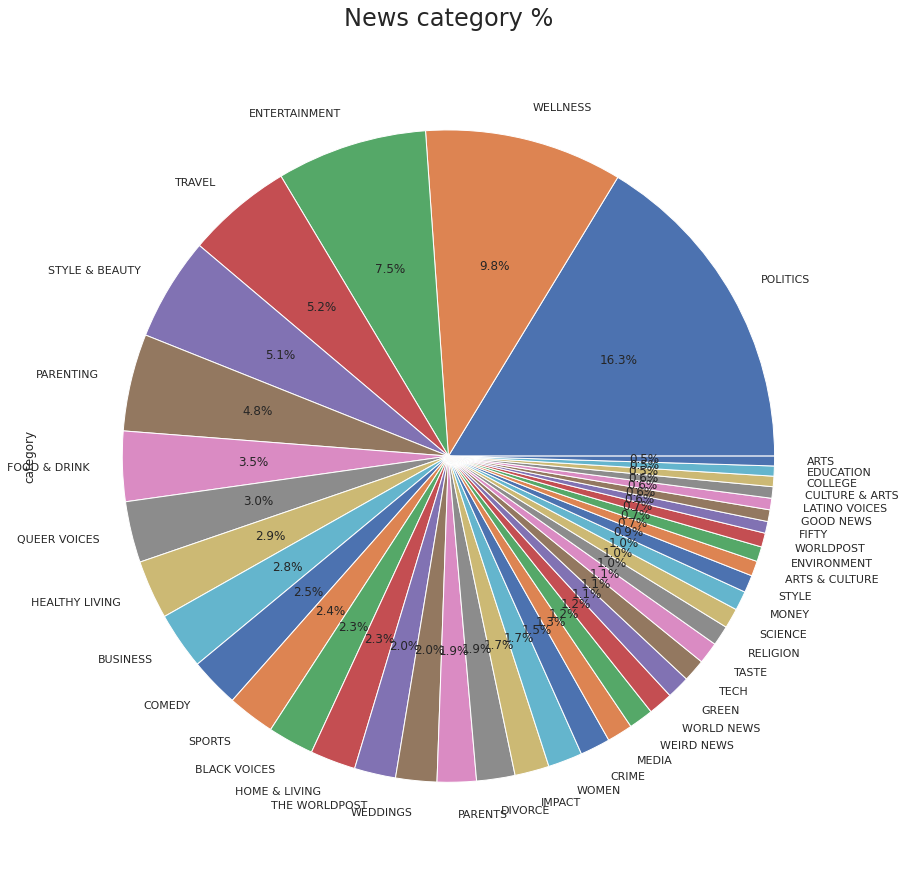

In [6]:
plt.title("News category %", y=1.02, fontdict={'fontsize': 24});
df['category'].value_counts().plot(kind='pie', figsize=(30,15), autopct="%.1f%%")

###4. Resampling danych w celu uzyskania takiej samej liczby danych dla każdej klasy

In [7]:
from imblearn.over_sampling import RandomOverSampler

X = df[['short_description']]
y = df[['category']]

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X, y)

ser1 = pd.Series(X_resampled.ravel())
ser2 = pd.Series(y_resampled)

data_res = pd.DataFrame(data=ser1, columns=['description'])
data_res['category'] = ser2

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

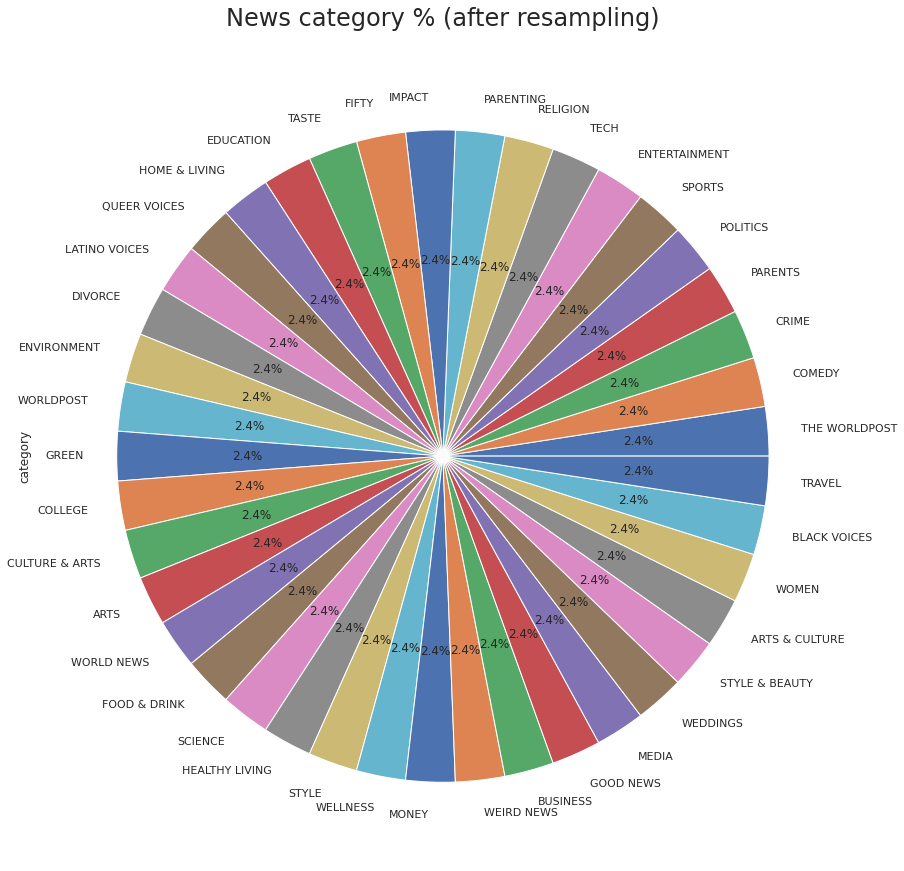

In [8]:
plt.title("News category % (after resampling)", y=1.02, fontdict={'fontsize': 24});
data_res['category'].value_counts().plot(kind='pie', figsize=(30,15), autopct="%.1f%%")

In [9]:
print(f'liczba rekordów przed resamplingiem: {len(df)}')
print(f'liczba rekordów po resamplingu: {len(data_res)}')

liczba rekordów przed resamplingiem: 178944
liczba rekordów po resamplingu: 1196667


###5. Zakodowanie kategorii oraz oczyszczenie tekstu w kolumnie z opisem

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def clean(text):

  tokens = word_tokenize(text)
  tokens = [w.lower() for w in tokens]

  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]

  words = [word for word in stripped if word.isalpha()]

  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]

  cleaned_text = ' '.join(words)

  return cleaned_text

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data_res['category'])
data_res['category'] = le.transform(data_res['category'])

In [13]:
data_res['description'] = data_res['description'].map(lambda x: clean(x))
data_res.head()

,description,category
0,left husband killed children another day america,6
1,course song,10
2,actor longtime girlfriend anna eberstein tied ...,10
3,actor gives dems asskicking fighting hard enou...,10
4,dietland actress said using bags really cathar...,10


###6. Wymieszanie danych

In [14]:
data_res = data_res.sample(frac=1).reset_index(drop=True)

###7. Wektoryzacja danych tektowych w celu umożliwienia zastosowania ich w modelu uczącym

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(data_res['description'])
y = data_res['category']

###8. Podział na zbiór treningowy i testowy

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

###9. Testowanie modeli (ustawienia domyślne)


*   LinearSVC



In [17]:
from sklearn.svm import LinearSVC

model1 = LinearSVC()
model1.fit(X_train, y_train)

print(f'Dokładność modelu: {model1.score(X_test, y_test)*100:.2f} %')

Dokładność modelu: 89.58 %




*   SGDClassifier



In [18]:
from sklearn.linear_model import SGDClassifier

model2 = SGDClassifier()
model2.fit(X_train, y_train)

print(f'Dokładność modelu: {model2.score(X_test, y_test)*100:.2f} %')

Dokładność modelu: 72.67 %




*   MultinomialNB



In [19]:
from sklearn.naive_bayes import MultinomialNB

model3 = MultinomialNB()
model3.fit(X_train, y_train)

print(f'Dokładność modelu: {model3.score(X_test, y_test)*100:.2f} %')

Dokładność modelu: 71.78 %
